In [1]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from stfe.gene_utils import get_markers
import scanpy as sc
from plotly3d.plot import trajectories
from sklearn.cluster import KMeans
import pandas as pd
import pathlib
from sklearn.preprocessing import StandardScaler

In [2]:
adata = sc.read_h5ad('../data/rna_figure_ready.h5ad')

In [3]:
gene_names = adata.var_names.to_numpy()

In [4]:
traj = np.load(f"../results_final_Dec22/traj_gene_space_T.npy", allow_pickle=True)

# sc.pp.highly_variable_genes(adata, n_top_genes=400)
alex_genes = open('../data/alex_genes.txt').read().splitlines()
alex_tfs = open('../data/alex_tfs.txt').read().splitlines()

alex_gene_all = list(set(alex_genes) | set(alex_tfs))
alex_gene_all_mask = np.isin(adata.var_names, alex_gene_all)
traj = traj[:, :, alex_gene_all_mask]
gene_names = adata.var_names[alex_gene_all_mask]

In [5]:
traj_mean = traj.mean(axis=1)
traj_std = traj.std(axis=1)
traj_mean_std = traj_mean.std(axis=0)
zero_std_genes = traj_mean_std == 0
gene_names = np.array(gene_names)[~zero_std_genes]
traj, traj_mean, traj_std, traj_mean_std = traj[..., ~zero_std_genes], traj_mean[..., ~zero_std_genes], traj_std[..., ~zero_std_genes], traj_mean_std[..., ~zero_std_genes]
traj_mean_normalized = (traj_mean - traj_mean.mean(axis=0)) / traj_mean.std(axis=0)

In [6]:
trends_df = pd.DataFrame(traj_mean_normalized, columns=gene_names, index=[f't{i}' for i in range(traj_mean_normalized.shape[0])]).T

In [7]:
km = KMeans(random_state=42, n_clusters=5)
km.fit(trends_df)
cluster_labels = km.labels_
start_vals = [km.cluster_centers_[i][0] for i in range(km.n_clusters)]
sorted_indices = np.argsort(start_vals)[::-1]  # Sort indices in descending order
reorder_map = {old_label: new_label for new_label, old_label in enumerate(sorted_indices)}
reordered_labels = np.array([reorder_map[label] for label in cluster_labels])
cluster_labels = reordered_labels + 1

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/mioflow/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(-2.5, 2.5)

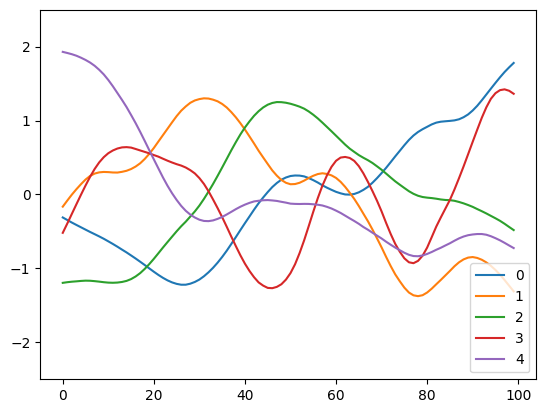

In [8]:
for i in range(len(np.unique(km.labels_))):
    plt.plot(km.cluster_centers_[i], label=i)
plt.legend()
plt.ylim(-2.5, 2.5)

In [9]:
# Use the predefined tab20 colormap
import matplotlib.pyplot as plt

# Function to convert numbers to colors using tab20 colormap
def lut(number):
    cmap = plt.get_cmap('tab20')
    return cmap(number / 20)  # Normalize the input to [0, 1]

In [10]:
row_colors = pd.Series(km.labels_, index=trends_df.index).apply(lut).rename("Cluster")


In [11]:
results_dir = pathlib.Path('../results_final_Dec22/cluster_heatmaps/')
results_dir.mkdir(exist_ok=True)

np.random.seed(23)

# Sort the DataFrame by cluster labels
sorted_df = trends_df.iloc[np.argsort(cluster_labels)]
sorted_row_colors = row_colors.iloc[np.argsort(cluster_labels)]
sorted_cluster_labels = cluster_labels[np.argsort(cluster_labels)]

# Save the data frames
sorted_df.to_csv(results_dir / f'sorted_df.csv')
pd.DataFrame(sorted_row_colors).to_csv(results_dir / f'sorted_row_colors.csv')
pd.DataFrame({'cluster_labels': sorted_cluster_labels}, index=sorted_df.index).to_csv(results_dir / f'sorted_cluster_labels.csv')


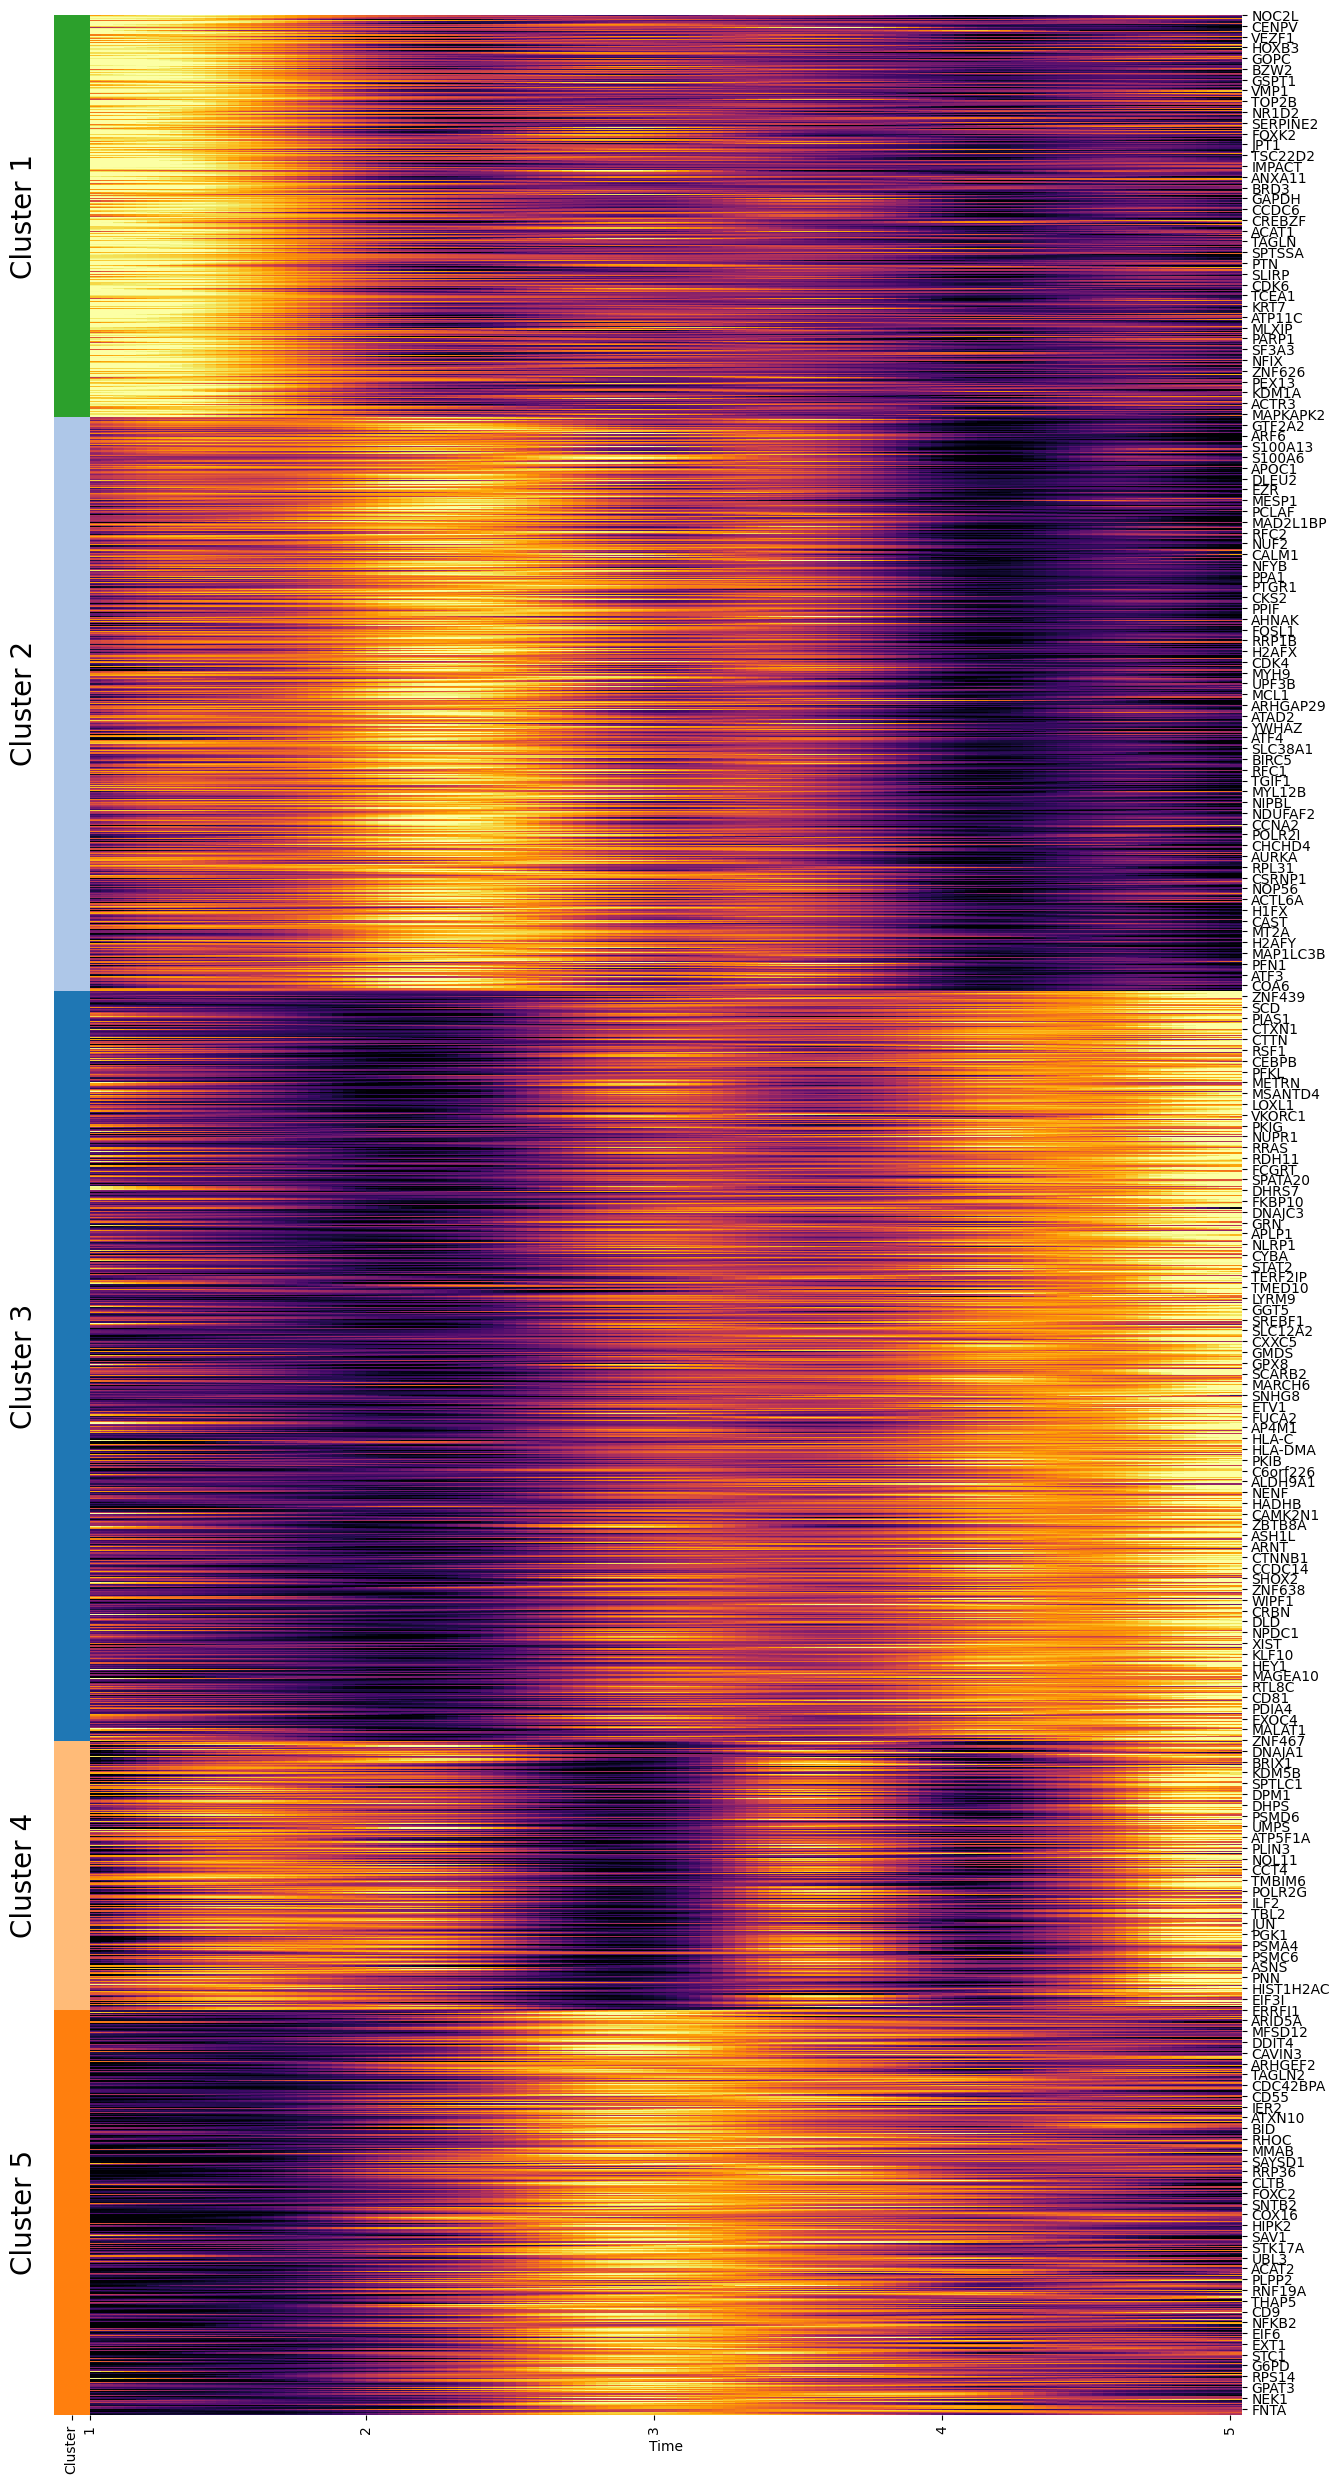

In [12]:
cl = sns.clustermap(
    sorted_df, col_cluster=False, cmap="inferno", robust=True, row_colors=sorted_row_colors,
    row_cluster=False,  # Disable row clustering to maintain the order
    cbar_pos=None,  # Remove the colorbar
    figsize=(12, 24)  # Adjust figure size for better layout
)
ax = cl.ax_heatmap
ax.set_xticks([0, 24, 49, 74, 99])
ax.set_xticklabels(np.arange(5) + 1)
names = sorted_df.index

# Set y-ticks to show one label every 100 genes
y_tick_positions = np.arange(0, len(names), 10)
ax.set_yticks(y_tick_positions)
ax.set_yticklabels(names[y_tick_positions])

ax.set_xlabel("Time")

# Adjust layout to remove extra margins
plt.tight_layout()

# Adjust the position of the main axes to fill the figure
cl.ax_heatmap.set_position([0.04, 0, 0.96, 1])

# Adjust the position of the row colors to align with the main heatmap
cl.ax_row_colors.set_position([0.01, 0, 0.03, 1])

# Add cluster labels to the left of the color blocks
ax_cluster_labels = cl.fig.add_axes([0, 0, 0.01, 1])
ax_cluster_labels.set_axis_off()

unique_labels = np.unique(sorted_cluster_labels)
for label in unique_labels:
    label_positions = np.where(sorted_cluster_labels == label)[0]
    mid_position = 1 - (label_positions[0] + label_positions[-1]) / 2 / len(sorted_cluster_labels)
    ax_cluster_labels.text(-0.3, mid_position, f'Cluster {label}', 
                           ha='right', va='center', rotation=90, transform=ax_cluster_labels.transAxes, fontsize=20)

plt.savefig(results_dir / f'cluster_heatmap.png', bbox_inches='tight', pad_inches=0.1)


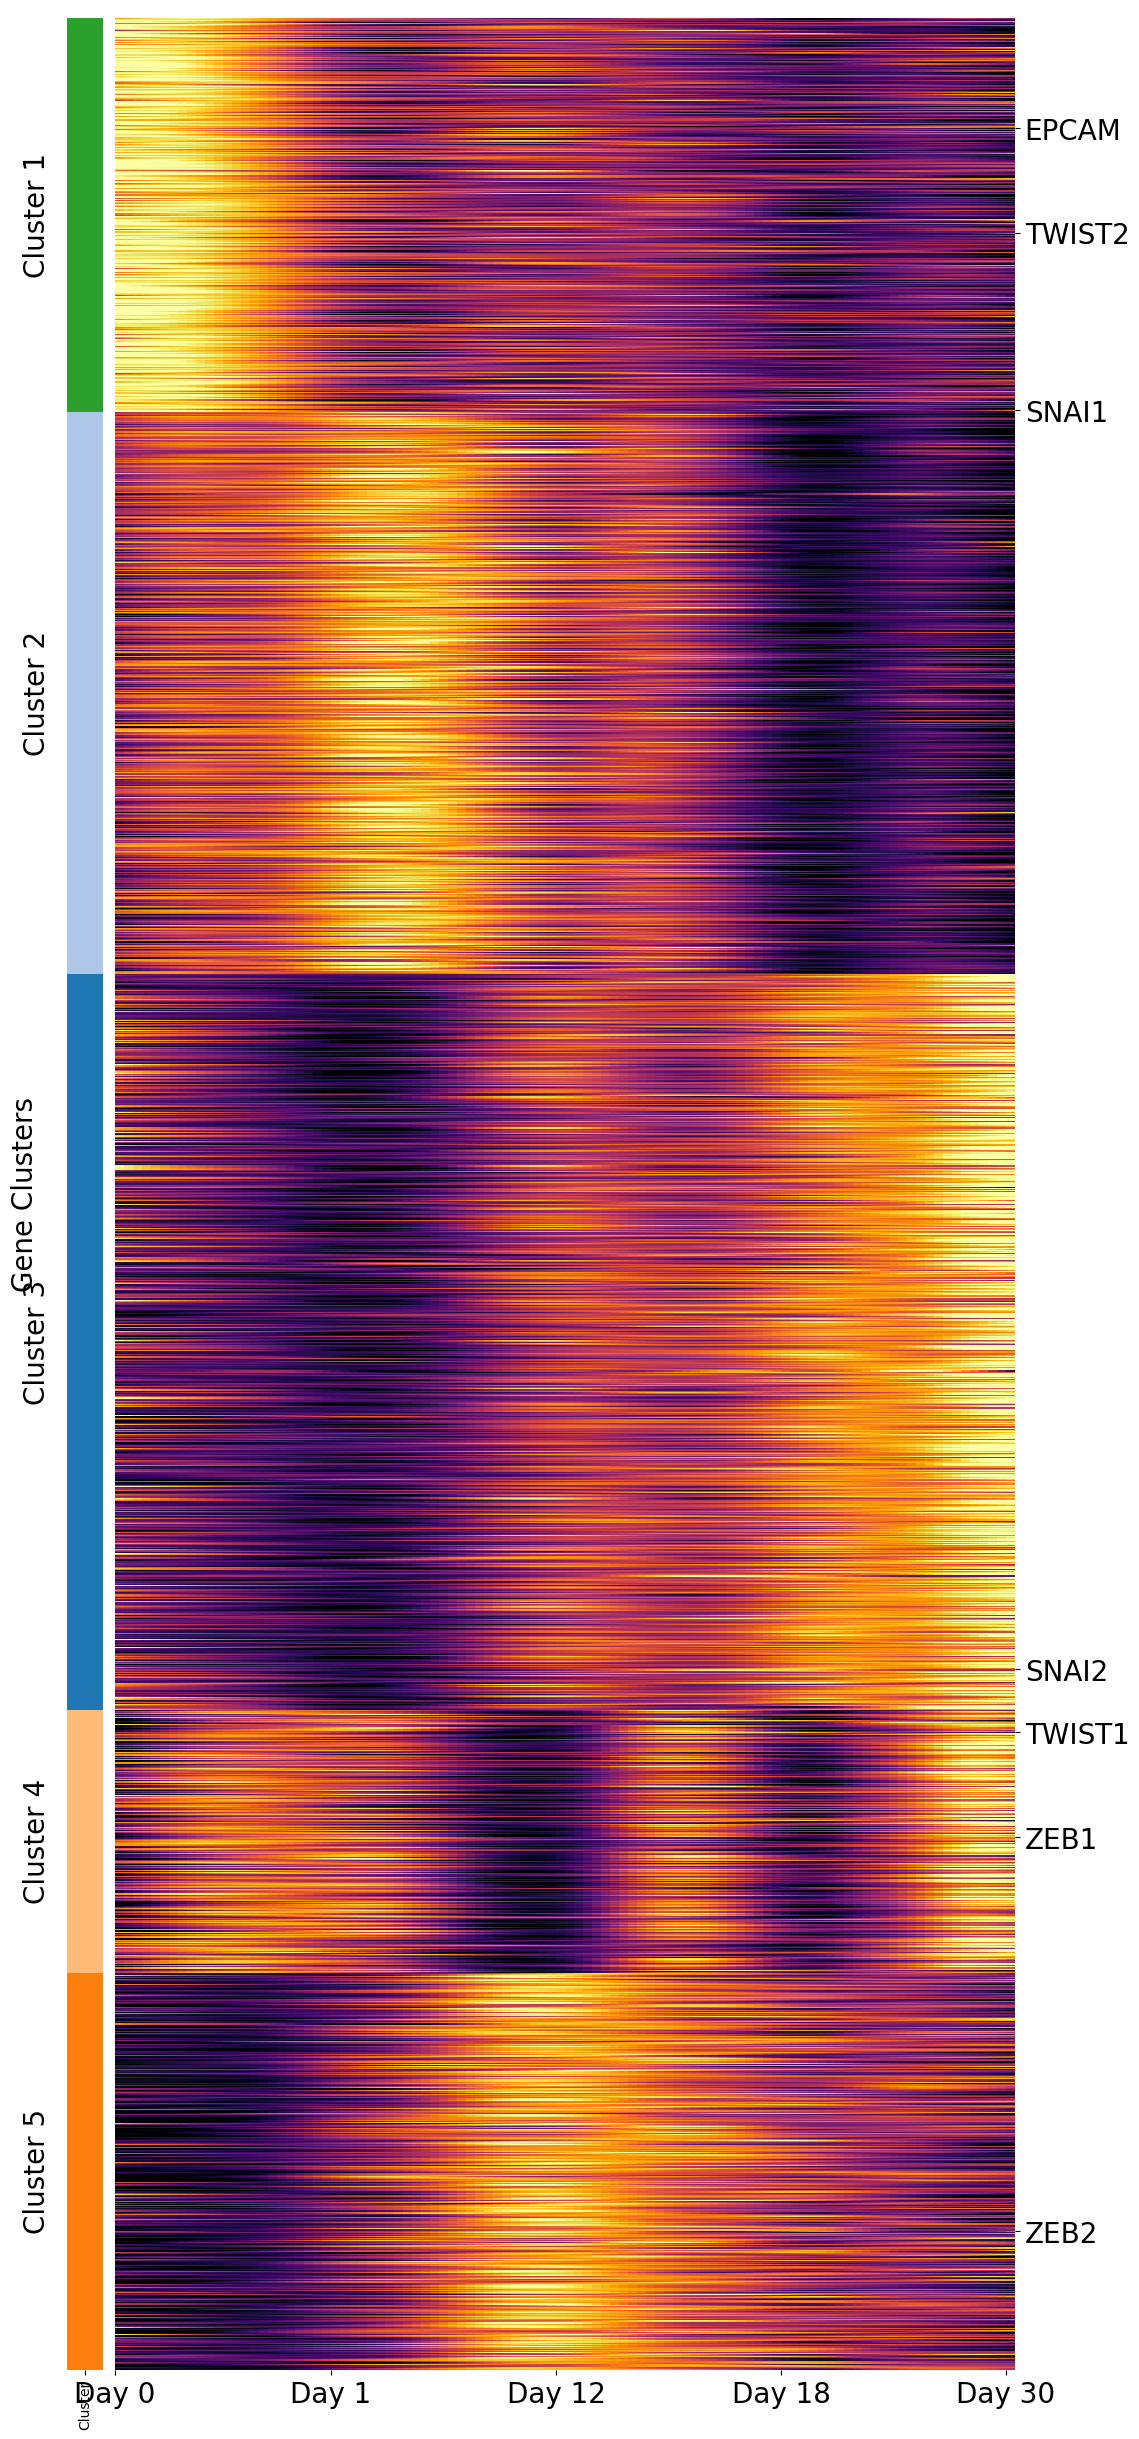

In [13]:
cl = sns.clustermap(
    sorted_df, col_cluster=False, cmap="inferno", robust=True, row_colors=sorted_row_colors,
    row_cluster=False,  # Disable row clustering to maintain the order
    cbar_pos=None,  # Remove the colorbar
    figsize=(12, 24)  # Adjust figure size for better layout
)

fontsize = 20

# Access heatmap axis
ax = cl.ax_heatmap

# Set x-ticks for time points
xticks_positions = [0, 24, 49, 74, 99]
xticks_labels = ["Day 0", "Day 1", "Day 12", "Day 18", "Day 30"]
ax.set_xticks(xticks_positions)
ax.set_xticklabels(xticks_labels, rotation=0, fontsize=fontsize)

# Highlight specific gene names on the right and remove others
highlighted_genes = ["EPCAM", "TWIST2", "SNAI1", "SNAI2", "TWIST1", "ZEB1", "ZEB2"]
highlighted_positions = [i for i, gene in enumerate(sorted_df.index) if gene in highlighted_genes]
ax.set_yticks(highlighted_positions)
ax.set_yticklabels(highlighted_genes, fontsize=fontsize)

# Adjust the position of the heatmap
cl.ax_heatmap.set_position([0.1, 0.01, 0.75, 0.98])  # Adjust for better alignment

# Adjust the position of the row colors
cl.ax_row_colors.set_position([0.06, 0.01, 0.03, 0.98])

# Add cluster labels to the left of the color blocks
ax_cluster_labels = cl.fig.add_axes([0.02, 0.01, 0.03, 0.98])  # Adjust position
ax_cluster_labels.set_axis_off()

# Add cluster labels
unique_labels = np.unique(sorted_cluster_labels)
for label in unique_labels:
    label_positions = np.where(sorted_cluster_labels == label)[0]
    mid_position = 1 - (label_positions[0] + label_positions[-1]) / 2 / len(sorted_cluster_labels)
    ax_cluster_labels.text(
        0.5, mid_position, f'Cluster {label}', 
        ha='center', va='center', rotation=90, transform=ax_cluster_labels.transAxes, fontsize=fontsize
    )

# Add "Gene Clusters" label to the left of the cluster labels
cl.fig.text(0.025, 0.5, "Gene Clusters", ha="center", va="center", rotation=90, fontsize=fontsize)

# Save the final figure
plt.savefig(results_dir / f'cluster_heatmap_fixed_layout.png', bbox_inches='tight', pad_inches=0.1)


In [14]:
cluster_df = pd.DataFrame({'cluster_labels': sorted_cluster_labels}, index=sorted_df.index)
gene_cluster_df = cluster_df.loc[alex_genes, :]
tf_cluster_df = cluster_df.loc[alex_tfs, :]
gene_cluster_df.to_csv(results_dir / f'gene_cluster_labels.csv')
tf_cluster_df.to_csv(results_dir / f'tf_cluster_labels.csv')